In [1]:
import xpress as xp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyreadr import read_r
from scipy.interpolate import interp1d
from param_watervalues import Reservoir
from time import time
import seaborn as sns

In [2]:
%load_ext line_profiler

In [3]:
%matplotlib widget

In [4]:
xp.controls.outputlog = 0
xp.controls.threads = 1
xp.controls.scaling = 0
xp.controls.presolve = 0
xp.controls.feastol = 1.e-7
xp.controls.optimalitytol = 1.e-7
xp.setOutputEnabled(False)

In [18]:
study_path = "D:/Users/gerbauxjul/Documents/6-Etudes Antares/thermal_heuristic_low_demand"
output_path = study_path+"/output/20240807-1721eco-exportmps_8_8"

In [19]:
def retrieve_problem(year,week,output_path,itr=1):
    model = xp.problem()
    model.read(output_path+f"/problem-{year}-{week}--optim-nb-{itr}.mps")
    return(model)

def modify_objective(model, u):
    cst = model.getConstraint()
    binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]
    model.chgrhs(binding_id,[u])
    return(model)

def milp_version(model):
    vars = model.getVariable()
    interger_vars = [i for i in range(len(vars)) if vars[i].name.strip().split("::")[0] in ['NODU', 'NumberBreakingDownDispatchableUnits', 'NumberStartingDispatchableUnits','NumberStoppingDispatchableUnits']]
    for i in interger_vars:
        model.chgcoltype([vars[i]],'I')
    return(model)

In [20]:
m = retrieve_problem(1,1,output_path,itr=1)

In [21]:
vars = m.getVariable()
len(vars)

2184

In [22]:
cons = m.getConstraint()
len(cons)

2353

In [23]:
m.solve()
m.getObjVal()

333212850.33721083

In [24]:
df_vars = pd.DataFrame(vars, columns=["names"])
df_vars["split"] = df_vars["names"].apply(lambda x:x.name.strip().split("::"))
df_vars["name_var"] = df_vars["split"].apply(lambda x:x[0])
df_vars["antares_object"] = df_vars["split"].apply(lambda x:x[1].split("<")[0])
df_vars["name_antares_object"] = df_vars["split"].apply(lambda x:x[1].split("<")[1].split(">")[0])
df_vars["subobject"] = df_vars["split"].apply(lambda x:x[2] if len(x)>=4 else "None")
df_vars["time"] = df_vars["split"].apply(lambda x:int(x[-1].split("<")[1].split(">")[0]))
df_vars["time_type"] = df_vars["split"].apply(lambda x:x[-1].split("<")[0])
coltype = []
m.getcoltype(coltype, 0, m.attributes.cols - 1)
df_vars['coltype'] = coltype
bounds = []
m.getlb(bounds, 0, m.attributes.cols - 1)
df_vars['lb'] = bounds
bounds = []
m.getub(bounds, 0, m.attributes.cols - 1)
df_vars['ub'] = bounds
objcoef = []
m.getobj(objcoef,0,m.attributes.cols-1)
df_vars= df_vars.assign(coeff=[objcoef[i] for i in range(m.attributes.cols)])
df_vars = df_vars.assign(sol=[m.getSolution(i) for i in range(m.attributes.cols)])
df_vars = df_vars.assign(obj = lambda x: np.round(df_vars['sol'],6)*np.round(df_vars['coeff'],6))

In [25]:
df_vars

,names,split,name_var,antares_object,name_antares_object,subobject,time,time_type,coltype,lb,ub,coeff,sol,obj
0,DispatchableProduction::area<area>::ThermalClu...,"[DispatchableProduction, area<area>, ThermalCl...",DispatchableProduction,area,area,ThermalCluster<Th1>,0,hour,C,0.0,4.500000e+04,99.999456,19789.0,1.978889e+06
1,DispatchableProduction::area<area>::ThermalClu...,"[DispatchableProduction, area<area>, ThermalCl...",DispatchableProduction,area,area,ThermalCluster<Th3>,0,hour,C,0.0,1.000000e+04,199.999493,0.0,0.000000e+00
2,PositiveUnsuppliedEnergy::area<area>::hour<0> ...,"[PositiveUnsuppliedEnergy, area<area>, hour<0>]",PositiveUnsuppliedEnergy,area,area,None,0,hour,C,0.0,1.978900e+04,2999.999412,0.0,0.000000e+00
3,NegativeUnsuppliedEnergy::area<area>::hour<0> ...,"[NegativeUnsuppliedEnergy, area<area>, hour<0>]",NegativeUnsuppliedEnergy,area,area,None,0,hour,C,0.0,1.000000e+20,9.999412,0.0,0.000000e+00
4,HydProd::area<area>::hour<0> ...,"[HydProd, area<area>, hour<0>]",HydProd,area,area,None,0,hour,C,0.0,0.000000e+00,-0.000945,0.0,-0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,NumberBreakingDownDispatchableUnits::area<area...,"[NumberBreakingDownDispatchableUnits, area<are...",NumberBreakingDownDispatchableUnits,area,area,ThermalCluster<Th3>,166,hour,C,0.0,0.000000e+00,0.000000,0.0,0.000000e+00
2180,NODU::area<area>::ThermalCluster<Th3>::hour<16...,"[NODU, area<area>, ThermalCluster<Th3>, hour<1...",NODU,area,area,ThermalCluster<Th3>,167,hour,C,0.0,1.000000e+01,10.000000,0.0,0.000000e+00
2181,NumberStartingDispatchableUnits::area<area>::T...,"[NumberStartingDispatchableUnits, area<area>, ...",NumberStartingDispatchableUnits,area,area,ThermalCluster<Th3>,167,hour,C,0.0,1.000000e+20,10.000000,0.0,0.000000e+00
2182,NumberStoppingDispatchableUnits::area<area>::T...,"[NumberStoppingDispatchableUnits, area<area>, ...",NumberStoppingDispatchableUnits,area,area,ThermalCluster<Th3>,167,hour,C,0.0,1.000000e+20,0.000000,0.0,0.000000e+00


In [26]:
df_vars["name_var"].unique()

array(['DispatchableProduction', 'PositiveUnsuppliedEnergy',
       'NegativeUnsuppliedEnergy', 'HydProd', 'NODU',
       'NumberStartingDispatchableUnits',
       'NumberStoppingDispatchableUnits',
       'NumberBreakingDownDispatchableUnits'], dtype=object)

In [27]:
df_vars[["name_var","obj"]].groupby("name_var").sum()

,obj
name_var,
DispatchableProduction,3.298628e+08
HydProd,0.000000e+00
NODU,3.995831e+04
NegativeUnsuppliedEnergy,2.367527e+04
NumberBreakingDownDispatchableUnits,0.000000e+00
NumberStartingDispatchableUnits,3.286434e+06
NumberStoppingDispatchableUnits,0.000000e+00
PositiveUnsuppliedEnergy,0.000000e+00


In [35]:
df_vars[(df_vars.time==77)]

,names,split,name_var,antares_object,name_antares_object,subobject,time,time_type,coltype,lb,ub,coeff,sol,obj
385,DispatchableProduction::area<area>::ThermalClu...,"[DispatchableProduction, area<area>, ThermalCl...",DispatchableProduction,area,area,ThermalCluster<Th1>,77,hour,C,0.0,4.500000e+04,99.999456,1743.000000,174299.051808
386,DispatchableProduction::area<area>::ThermalClu...,"[DispatchableProduction, area<area>, ThermalCl...",DispatchableProduction,area,area,ThermalCluster<Th3>,77,hour,C,0.0,1.000000e+04,199.999493,0.000000,0.000000
387,PositiveUnsuppliedEnergy::area<area>::hour<77>...,"[PositiveUnsuppliedEnergy, area<area>, hour<77>]",PositiveUnsuppliedEnergy,area,area,None,77,hour,C,0.0,1.743000e+03,2999.999412,0.000000,0.000000
388,NegativeUnsuppliedEnergy::area<area>::hour<77>...,"[NegativeUnsuppliedEnergy, area<area>, hour<77>]",NegativeUnsuppliedEnergy,area,area,None,77,hour,C,0.0,1.000000e+20,9.999412,0.000000,0.000000
389,HydProd::area<area>::hour<77> ...,"[HydProd, area<area>, hour<77>]",HydProd,area,area,None,77,hour,C,0.0,0.000000e+00,-0.000836,0.000000,-0.000000
1148,NODU::area<area>::ThermalCluster<Th1>::hour<77...,"[NODU, area<area>, ThermalCluster<Th1>, hour<77>]",NODU,area,area,ThermalCluster<Th1>,77,hour,C,0.0,5.000000e+01,10.000000,1.936667,19.366670
1149,NumberStartingDispatchableUnits::area<area>::T...,"[NumberStartingDispatchableUnits, area<area>, ...",NumberStartingDispatchableUnits,area,area,ThermalCluster<Th1>,77,hour,C,0.0,1.000000e+20,25000.000000,1.457778,36444.450000
1150,NumberStoppingDispatchableUnits::area<area>::T...,"[NumberStoppingDispatchableUnits, area<area>, ...",NumberStoppingDispatchableUnits,area,area,ThermalCluster<Th1>,77,hour,C,0.0,1.000000e+20,0.000000,0.000000,0.000000
1151,NumberBreakingDownDispatchableUnits::area<area...,"[NumberBreakingDownDispatchableUnits, area<are...",NumberBreakingDownDispatchableUnits,area,area,ThermalCluster<Th1>,77,hour,C,0.0,0.000000e+00,0.000000,0.000000,0.000000
1820,NODU::area<area>::ThermalCluster<Th3>::hour<77...,"[NODU, area<area>, ThermalCluster<Th3>, hour<77>]",NODU,area,area,ThermalCluster<Th3>,77,hour,C,0.0,1.000000e+01,10.000000,0.000000,0.000000


<Axes: xlabel='time', ylabel='sol'>

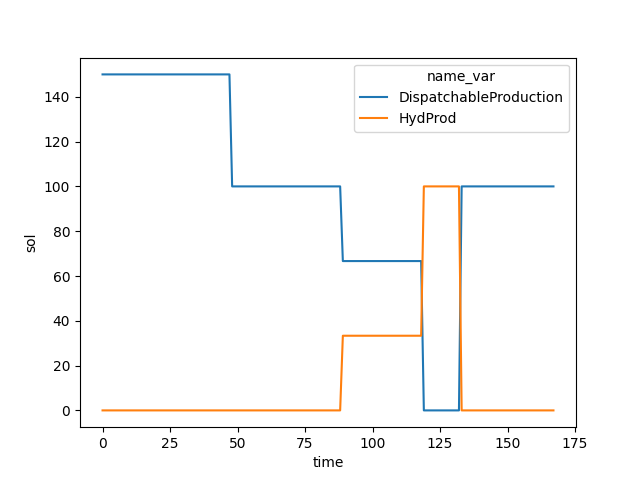

In [24]:
plt.figure()
sns.lineplot(data=df_vars[df_vars.name_var.isin(['HydProd','DispatchableProduction'])],x="time",y="sol",hue="name_var")

In [76]:
df_cons = pd.DataFrame(cons, columns=["names"])
df_cons["split"] = df_cons["names"].apply(lambda x:x.name.strip().split("::"))
df_cons["name_cons"] = df_cons["split"].apply(lambda x:x[0])
df_cons["antares_object"] = df_cons["split"].apply(lambda x:x[1].split("<")[0])
df_cons["name_antares_object"] = df_cons["split"].apply(lambda x:x[1].split("<")[1].split(">")[0] if len(x[1].split("<"))>=2 else "None")
df_cons["time"] = df_cons["split"].apply(lambda x:int(x[-1].split("<")[1].split(">")[0]))
df_cons["time_type"] = df_cons["split"].apply(lambda x:x[-1].split("<")[0])
rhs = []
m.getrhs(rhs, 0, m.attributes.rows - 1)
df_cons["rhs"] = rhs

In [77]:
df_cons

,names,split,name_cons,antares_object,name_antares_object,time,time_type,rhs
0,AreaBalance::area<area>::hour<0> ...,"[AreaBalance, area<area>, hour<0>]",AreaBalance,area,area,0,hour,-20.0
1,FictiveLoads::area<area>::hour<0> ...,"[FictiveLoads, area<area>, hour<0>]",FictiveLoads,area,area,0,hour,0.0
2,AreaBalance::area<area>::hour<1> ...,"[AreaBalance, area<area>, hour<1>]",AreaBalance,area,area,1,hour,-20.0
3,FictiveLoads::area<area>::hour<1> ...,"[FictiveLoads, area<area>, hour<1>]",FictiveLoads,area,area,1,hour,0.0
4,AreaBalance::area<area>::hour<2> ...,"[AreaBalance, area<area>, hour<2>]",AreaBalance,area,area,2,hour,-20.0
...,...,...,...,...,...,...,...,...
1511,MinDownTime::area<area>::ThermalCluster<cluste...,"[MinDownTime, area<area>, ThermalCluster<clust...",MinDownTime,area,area,163,hour,15.0
1512,MinDownTime::area<area>::ThermalCluster<cluste...,"[MinDownTime, area<area>, ThermalCluster<clust...",MinDownTime,area,area,164,hour,15.0
1513,MinDownTime::area<area>::ThermalCluster<cluste...,"[MinDownTime, area<area>, ThermalCluster<clust...",MinDownTime,area,area,165,hour,15.0
1514,MinDownTime::area<area>::ThermalCluster<cluste...,"[MinDownTime, area<area>, ThermalCluster<clust...",MinDownTime,area,area,166,hour,15.0


In [78]:
df_cons["name_cons"].unique()

array(['AreaBalance', 'FictiveLoads', 'HydroPower', 'MinHydroPower',
       'MaxHydroPower', 'MaxPumping', 'AreaHydroLevel',
       'PMaxDispatchableGeneration', 'PMinDispatchableGeneration',
       'ConsistenceNODU', 'NbUnitsOutageLessThanNbUnitsStop',
       'NbDispUnitsMinBoundSinceMinUpTime', 'MinDownTime'], dtype=object)

In [30]:
m.write("problem.lp","l")

## plot

In [50]:
load = np.loadtxt("load_res.txt")

In [51]:
hours_week = list(range(168))

In [67]:
def plot(gas_prod, step):
    fig, ax = plt.subplots()
    ax.step(hours_week,load,label="Residual load",color="black",where='post')
    ax.plot(hours_week,[125]*168,label="P_min")
    ax.step(hours_week,[125 if t in [7,8] else 0 for t in range(168)],label="Heuristic min gen",where='post')
    ax.stackplot(hours_week,[gas_prod,step],labels=["Gas production","Hydro production"], step='post')
    plt.legend()
    plt.xlim((0,24))
    plt.show()
    plt.xlabel("Hour")
    plt.ylabel("Energy (MWh)")


In [68]:
gas_prod = [0]*168
gas_prod[7] = 424
gas_prod[8] = 125
gas_prod[17] = 68
step = np.array(load)-np.array(gas_prod)
sum(np.where(step>0,step,0))-0.75*sum(np.where(step<0,-step,0))

-14.0

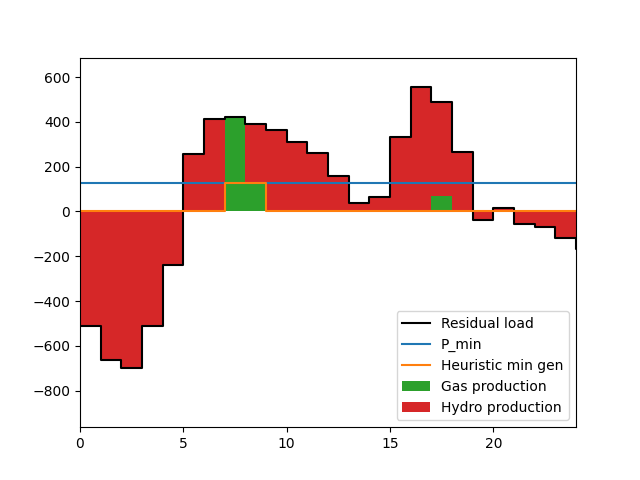

In [69]:
plot(gas_prod,step)

In [70]:
gas_prod = [0]*168
gas_prod[7] = 424
gas_prod[8] = 125+68
gas_prod[17] = 0
step = np.array(load)-np.array(gas_prod)
sum(np.where(step>0,step,0))-0.75*sum(np.where(step<0,-step,0))

-14.0

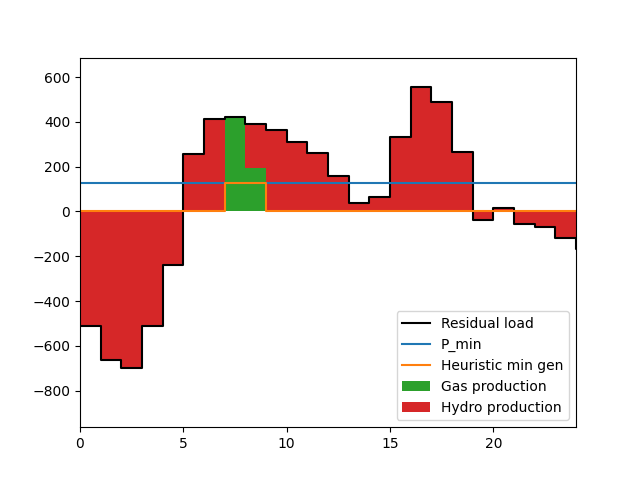

In [71]:
plot(gas_prod,step)